# Derive cancer and stroma masks in CosMx data



In [1]:
%load_ext autoreload

import os 
import sys
import time
import logging
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from natsort import natsorted

import cv2
import numpy as np
from PIL import Image
import tifffile as tiff
import copy 

sys.path.append(os.path.dirname(os.getcwd()))

from src import get_arrays as ga
from src import contours 
from src import masks
from src.mask_properties import GetMasksProperties

In [2]:
# define the logger :  can be None, and is set to INFO
# Custom logger setup
logger = logging.getLogger('contour_logger')
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

# Cosmx Data

Resolution
1 px = 125 nm = 0.125 um
1 um = 8 px

Transcripts -> 999 + system and negative controls

standard panel (not custom made)

CRC cohort

In [3]:
cosmx_path_s0 =  '../../cosmx_data/S0/S0/20230628_151317_S4/AnalysisResults/iz38iruwno'

folder_names_s0 = [folder_name for folder_name in os.listdir(cosmx_path_s0) if
                os.path.isdir(os.path.join(cosmx_path_s0, folder_name))]

target_files_s0 = [
    os.path.join(cosmx_path_s0, folder, file)
    for folder in os.listdir(cosmx_path_s0)
    if os.path.isdir(os.path.join(cosmx_path_s0, folder))
    for file in os.listdir(os.path.join(cosmx_path_s0, folder))
    if '__target_call_coord.csv' in file
]


files_names = natsorted(target_files_s0)
files_cosmx = copy.deepcopy(files_names)
# files_names

Let's open one file to see how it looks like

In [4]:
file_csv = files_names[0]   # 5
print(file_csv)
df_total = pd.read_csv(file_csv)
df_total['X'] = (round(df_total['x'])).astype(int)
df_total['Y'] = (round(df_total['y'])).astype(int)

print('max x', max(df_total['x']))
print('max y', max(df_total['y']))
print('rounded max x', max(df_total['X']))
print('rounded max y', max(df_total['Y']))

print('df shape', df_total.shape)
print('df columns', df_total.columns)

df_total['target'].value_counts()

../../cosmx_data/S0/S0/20230628_151317_S4/AnalysisResults/iz38iruwno/FOV001/Run_69de8227-1a7b-40ee-ba46-0ea99a7c59f4_FOV001__target_call_coord.csv
max x 4245.27
max y 4245.32
rounded max x 4245
rounded max y 4245
df shape (1843019, 22)
df columns Index(['Unnamed: 0', 'Spot1_count', 'Spot2_count', 'Spot3_count',
       'Spot4_count', 'codeclass', 'fov', 'multicolor_spots_per_feature',
       'possible_BC_count', 'random_call_probability', 'seed_x', 'seed_y',
       'spots_per_feature', 'target', 'target_call_observations',
       'target_count_per_feature', 'target_idx', 'x', 'y', 'z', 'X', 'Y'],
      dtype='object')


target
MALAT1              110996
TPT1                 67199
KRT8                 48690
RPL37                46842
KRT18                41968
                     ...  
SystemControl194         7
SystemControl10          6
SystemControl107         4
SystemControl70          3
SystemControl134         2
Name: count, Length: 1207, dtype: int64

Remove the negative controls. We get 999 genes and shape (4245,4245)

In [5]:
# remove Controls
df_total = df_total[~df_total['target'].str.contains('System|egative')]
n_genes = len(df_total['target'].unique())
height = max(df_total['X'] + 1)
width = max(df_total['Y'] + 1)

print(f'n genes: {n_genes}')
print(f'shape: {height}, {width}')
print(f'n hits {len(df_total)}')

n genes: 999
shape: 4246, 4246
n hits 1819904


Define GRIDGEN parameters and obtain arrays

In [6]:
target_tum =  ['EPCAM',  'KRT19', 'KRT8', 'KRT18','KRT17','CEACAM6','SPINK1', 'CD24', 'S100A6','RPL37','S100P',]  

# param tum
density_th_tum = 40    
min_area_th_tum =  1000 
kernel_size_tum = 80

# param empty
density_th_empty = 140
min_area_th_empty = 2000 
kernel_size_empty = 80

In [7]:
# this makes the sparse df to an array with the spatial information 
target_dict_total = {target: index for index, target in enumerate(df_total['target'].unique())}
array_total = ga.transform_df_to_array(df = df_total, target_dict=target_dict_total, array_shape = (height, width,len(target_dict_total))).astype(np.int8)

# creating subsets 
df_subset_tum, array_subset_tum, target_indices_subset_tum = ga.get_subset_arrays(df_total, array_total,target_dict_total,
                                                                     target_list=target_tum, target_col = 'target')

We are set to go! Lets get the contours: 
 - Contours for the cancer regions using the cancer trasncripts.
 - Contours around the regions that have tissue (emptiness) using all the transcripts available.

We will plot the results with the graphics available in GRIDGEN: 
 - contours scatter - where each transcript point of that region is blue and the contour is red. 
 - conv sum - plot with the convolutional sum image ( densities on each kernel). 
 


Function 'get_conv_sum' took 0.5181 seconds to execute.
Function 'contours_from_sum' took 31.6562 seconds to execute.
==== tumour ====
total contours found  917
total contours after filtering by area 35
Function 'get_conv_sum' took 7.3329 seconds to execute.
Function 'contours_from_sum' took 12.7785 seconds to execute.
====
total contours found  177
total contours after filtering by area 35


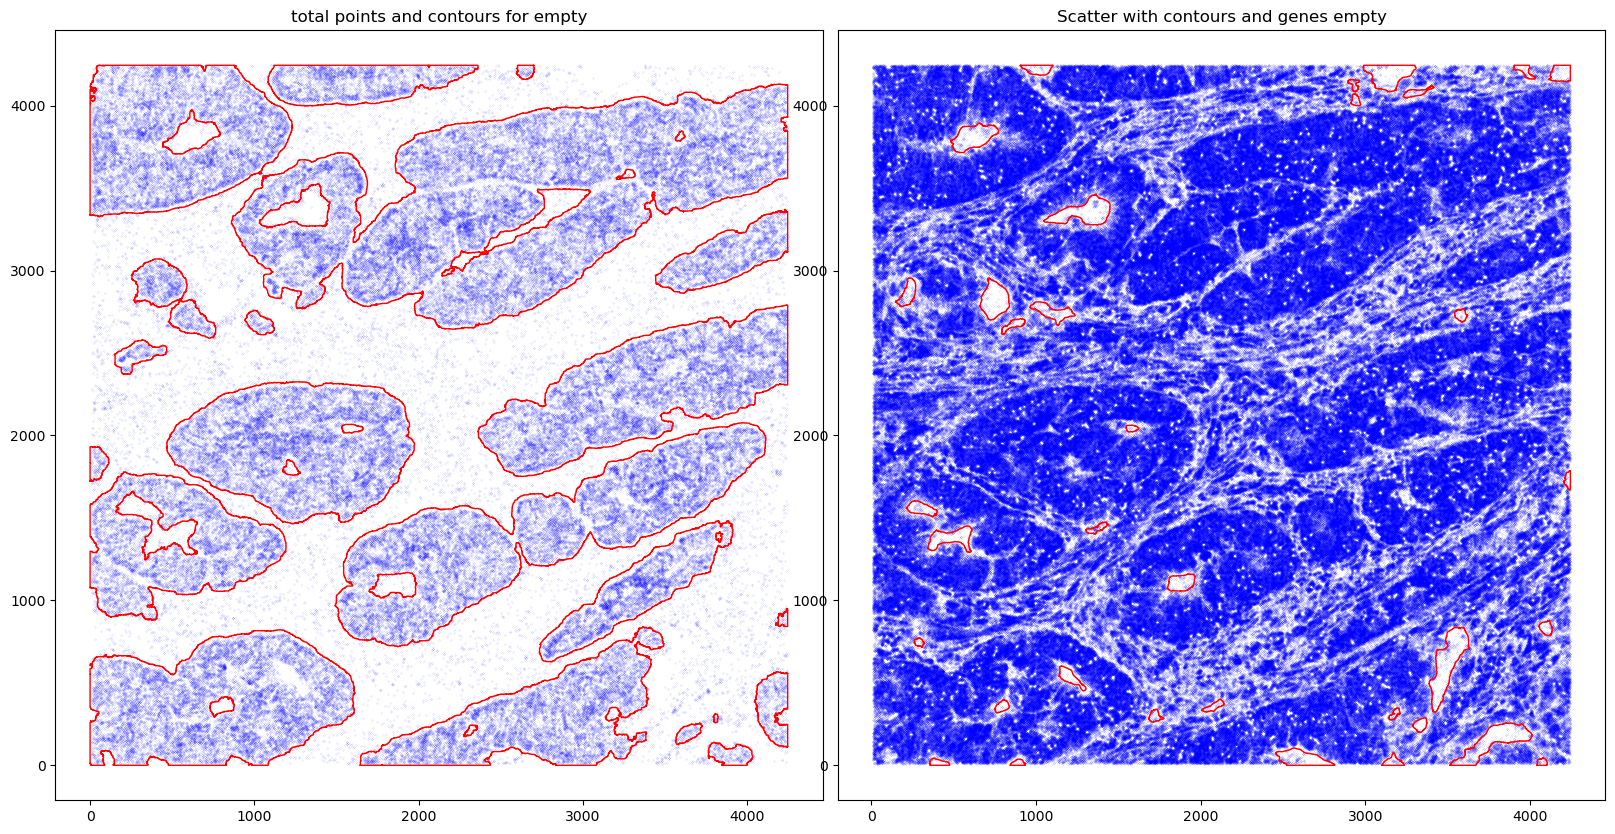

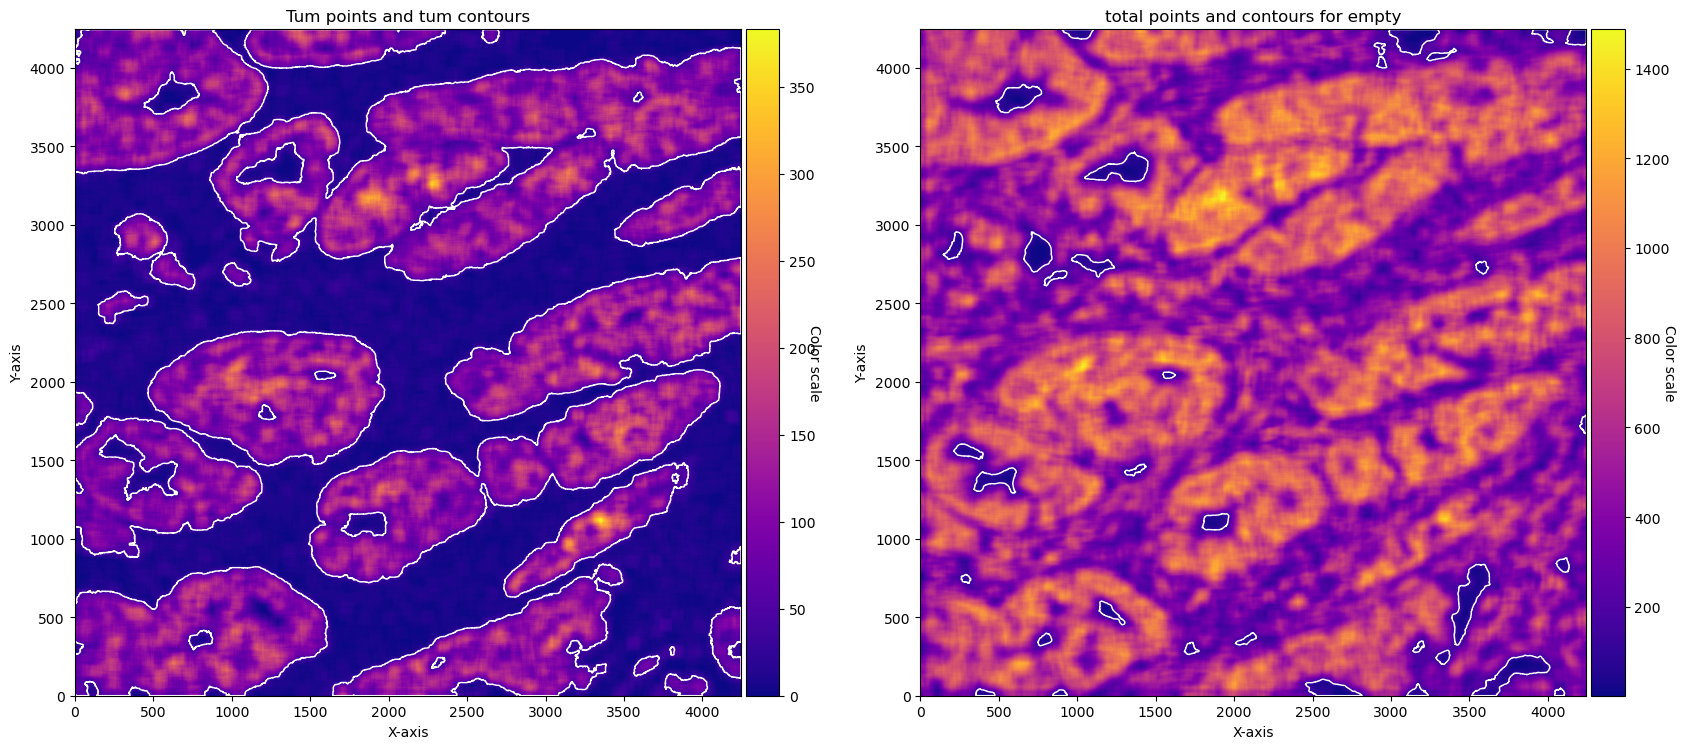

In [8]:
# obtain contours 
CTum = contours.ConvolutionContours(array_subset_tum, contour_name='tum')
CTum.get_conv_sum(kernel_size=kernel_size_tum, kernel_shape='square')
CTum.contours_from_sum(density_threshold = density_th_tum,
                       min_area_threshold = min_area_th_tum , directionality = 'higher')

print('==== tumour ====')
print('total contours found ', CTum.total_valid_contours)
print('total contours after filtering by area', CTum.contours_filtered_area)

CEmpty = contours.ConvolutionContours(array_total, contour_name='empty')
CEmpty.get_conv_sum(kernel_size=kernel_size_empty, kernel_shape='square')
CEmpty.contours_from_sum(density_threshold = density_th_empty,
                       min_area_threshold = min_area_th_empty, directionality = 'lower') # attention that directionality is lower here 


print('====')
print('total contours found ', CEmpty.total_valid_contours)
print('total contours after filtering by area', CEmpty.contours_filtered_area)

# PLOTs -- instead of plotting just with the function for example: CTum.plot_contours_scatter, we will make a composite image 

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
CTum.plot_contours_scatter(path=None, show=False, s=0.05, alpha=0.5, linewidth=1,
                           c_points= 'blue',c_contours= 'red', ax=axs[0])
axs[0].set_title('Tum points and tum contours')  


CEmpty.plot_contours_scatter(path=None, show=False, s=0.05, alpha=0.5, linewidth=1,
                           c_points= 'blue',c_contours= 'red', ax=axs[1])
axs[0].set_title('total points and contours for empty')  
plt.subplots_adjust(wspace=0.02)  # Adjust to your preference

plt.show()
   

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

CTum.plot_conv_sum(cmap='plasma', c_countour='white', ax=axs[0])
axs[0].set_title('Tum points and tum contours')

CEmpty.plot_conv_sum(cmap='plasma', c_countour='white', ax=axs[1])
axs[1].set_title('total points and contours for empty')

plt.show()

With the contours made. We can make the masks. 
cancer masks will be equivalent to the cancer contours. 
Stroma masks will be the total tissue contours without the cancer areas. 

Some operations can be done to get smoother masks. In the example below, holes in tumour masks are filled. This is optional. 

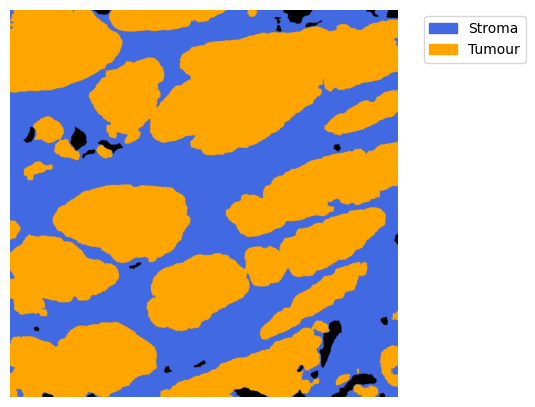

In [9]:
#### obtain masks
GM = masks.GetMasks(image_shape = (height, width))

mask_empty = GM.create_mask(CEmpty.contours)
mask_tum = GM.create_mask(CTum.contours)
mask_tum = GM.fill_holes(mask_tum)
mask_stroma = GM.subtract_masks(np.ones((height, width), dtype=np.uint8), mask_tum, mask_empty)          
mask_stroma = GM.filter_mask_by_area(mask_stroma, min_area=700)

# general masks 
GM.mask_S = mask_stroma
GM.mask_T = mask_tum

GM.plot_masks(masks=[GM.mask_S, GM.mask_T], mask_names=['Stroma', 'Tumour'],
              background_color=(1, 1, 1), mask_colors={'Stroma': (65, 105, 225), 'Tumour': (255, 165, 0)},
              path=None, show=True, ax=None, figsize=(5, 6))

Just as an example, We will overlay this mask with the immunofluorescent image. 
In the IF image tumour is coloured with DAPI blue, cancer with red and the remaining memabranes with green. In yellow stroma contours and in white cancer contours. 

It's pssible to see a very good overlap between regions. discrepancies may be due to problems in the imaging and the non complete alignment as the IF and the CosMx are made on consecutive slides.

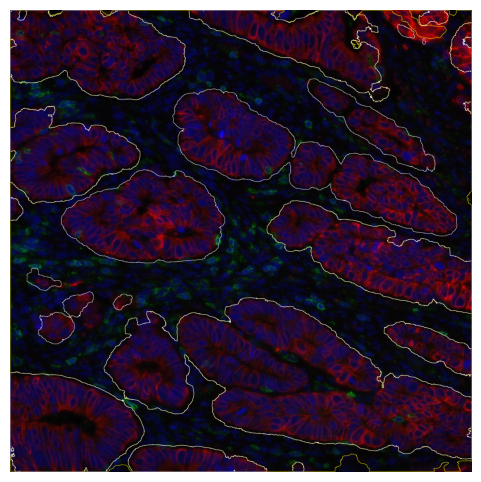

In [10]:
mask1 = GM.mask_S
mask2 = GM.mask_T
image = tiff.imread('composites/20230628_151317_S4_C902_P99_N99_F001_composite.tiff')

# Calculate the padding needed on each side
pad_y = (image.shape[1] - mask1.shape[1]) // 2
pad_x = (image.shape[0] - mask1.shape[0]) // 2

# Pad the mask with 5 pixels on each side to match the image size
# Here, we assume a binary mask, so we pad with 0s
mask1 = np.pad(mask1, ((pad_y, pad_y), (pad_x, pad_x)), mode='constant', constant_values=0)
mask2 = np.pad(mask2, ((pad_y, pad_y), (pad_x, pad_x)), mode='constant', constant_values=0)

# mask1 = np.flip(mask1, axis = 0) 
mask1 = np.transpose(mask1)
mask2 = np.transpose(mask2)
image = (image * 255).astype(np.uint8)

# Create a copy of the image to overlay borders
image_with_contours = image.copy()

# Find contours for each mask
contours1, _ = cv2.findContours(mask1.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours2, _ = cv2.findContours(mask2.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Define colors for each mask's contours (Yellow for mask1, Cyan for mask2)
contour_color1 = (255, 255, 0)  # Yellow
contour_color2 = (255, 255, 255)  # Cyan

# Draw the contours on the image
cv2.drawContours(image_with_contours, contours1, -1, contour_color1, thickness=2)
cv2.drawContours(image_with_contours, contours2, -1, contour_color2, thickness=2)

# Plot the image with contours
plt.figure(figsize=(6, 6))  # Increase the figure size to make it larger
plt.imshow(image_with_contours)
plt.axis('off')  # Hide axes for cleaner visualization
plt.show()

Finally, we can wrap the pipleine in a function and apply it to the full cohort. 

In [11]:
def do_cosmx_pipeline(file_csv):
    df_total = pd.read_csv(file_csv)
    df_total['X'] = (round(df_total['x'])).astype(int)
    df_total['Y'] = (round(df_total['y'])).astype(int)
    n_genes = len(df_total['target'].unique())
    height = max(df_total['X'] + 1)
    width = max(df_total['Y'] + 1)

    # this makes the sparse df to an array with the spatial information 
    target_dict_total = {target: index for index, target in enumerate(df_total['target'].unique())}
    array_total = ga.transform_df_to_array(df = df_total, target_dict=target_dict_total, array_shape = (height, width,len(target_dict_total))).astype(np.int8)
    
    # creating subsets 
    df_subset_tum, array_subset_tum, target_indices_subset_tum = ga.get_subset_arrays(df_total, array_total,target_dict_total,
                                                                         target_list=target_tum, target_col = 'target')
    
    # obtain contours 
    CTum = contours.ConvolutionContours(array_subset_tum, contour_name='tum')
    CTum.get_conv_sum(kernel_size=kernel_size_tum, kernel_shape='square')
    CTum.contours_from_sum(density_threshold = density_th_tum,
                           min_area_threshold = min_area_th_tum , directionality = 'higher')
    print('==== tumour ====')
    print('total contours found ', CTum.total_valid_contours)
    print('total contours after filtering by area', CTum.contours_filtered_area)
    
    CEmpty = contours.ConvolutionContours(array_total, contour_name='empty')
    CEmpty.get_conv_sum(kernel_size=kernel_size_empty, kernel_shape='square')
    CEmpty.contours_from_sum(density_threshold = density_th_empty,
                           min_area_threshold = min_area_th_empty, directionality = 'lower') # attention that directionality is lower here 
    
    print('====')
    print('total contours found ', CEmpty.total_valid_contours)
    print('total contours after filtering by area', CEmpty.contours_filtered_area)

    
    # PLOTs -- instead of plotting just with the function for example: CTum.plot_contours_scatter, we will make a composite image 
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    CTum.plot_contours_scatter(path=None, show=False, s=0.05, alpha=0.5, linewidth=1,
                               c_points= 'blue',c_contours= 'red', ax=axs[0])
    axs[0].set_title('Tum points and tum contours')  
    
    
    CEmpty.plot_contours_scatter(path=None, show=False, s=0.05, alpha=0.5, linewidth=1,
                               c_points= 'blue',c_contours= 'red', ax=axs[1])
    axs[0].set_title('total points and contours for empty')  
    plt.subplots_adjust(wspace=0.02)  # Adjust to your preference
    
    plt.show()
    
    #### obtain masks
    GM = masks.GetMasks(image_shape = (height, width))
    
    mask_empty = GM.create_mask(CEmpty.contours)
    mask_tum = GM.create_mask(CTum.contours)
    mask_tum = GM.fill_holes(mask_tum)
    mask_stroma = GM.subtract_masks(np.ones((height, width), dtype=np.uint8), mask_tum, mask_empty)          
    mask_stroma = GM.filter_mask_by_area(mask_stroma, min_area=700)
    
    # general masks 
    GM.mask_S = mask_stroma
    GM.mask_T = mask_tum
    
    GM.plot_masks(masks=[GM.mask_S, GM.mask_T], mask_names=['Stroma', 'Tumour'],
                  background_color=(1, 1, 1), mask_colors={'Stroma': (65, 105, 225), 'Tumour': (255, 165, 0)},
                  path=None, show=True, ax=None, figsize=(6, 6))

In [ ]:
%%time
for file_csv in tqdm(files_names[:10]):
    do_cosmx_pipeline(file_csv)

  0%|                                                                                                                                                        | 0/10 [00:00<?, ?it/s]